In [171]:
struct Affine
  W
  b
end

Affine(in::Integer, out::Integer) =
  Affine(randn(out, in), randn(out))

# Overload call, so the object can be used as a function
(m::Affine)(x) = m.W * x .+ m.b

Flux.@functor Affine

a = Affine(10, 5)

print(a(rand(10))) # => 5-element vector

print(params(a))

[-2.913690576735439, 1.680096213816824, 0.28042594828394396, -0.20710286855489635, -3.458704953473351]Params([[-1.2923018139015066 -2.2762971566738424 -0.31915387059863726 -2.7097659855963068 -0.1865685189189666 0.8317019826253725 -0.28357050613329476 1.2727100783039857 1.6656613179392814 0.30945257206772014; 0.6584070971804954 -0.3381003813811993 -0.7865215899936169 -0.030493177819733958 0.027940318651576784 -0.17310197606310698 0.10216988430682783 0.6101148544467195 0.44822384200756726 0.06897801389836204; 0.8664252004755161 -0.07319829870689396 -0.7084270694064926 0.7178162882414111 1.4102572352412897 -0.4629203003660491 0.5454456984656663 0.03033769404470417 0.008790878569853168 0.29741717649553673; -1.2524609409763776 0.6527657315311807 0.40147194756281035 1.921955586120817 -0.7476380692320742 -1.07260751998132 -1.306146115125514 1.5142744743849161 0.9251027949558233 0.4496975092754528; -1.5066804990162048 0.7415027539072672 1.6553568289815837 -1.6466128542968894 -1.35017662262783

In [10]:

using Statistics
#using CuArrays
using Random
using Zygote
using Flux, Flux.Optimise
using Metalhead, Images
using Metalhead: trainimgs
using Images.ImageCore
using Flux: onehotbatch, onecold
using Base.Iterators: partition


In [164]:
ReLUConvBN(C_in, C_out, kernel_size, stride, pad) = Chain(
    relu,
    Conv(kernel_size, C_in->C_out, pad=pad, stride=stride),
    BatchNorm(C_out))

FactorizedReduce(C_in, C_out, stride) = Chain(
    relu,
    Chain(x -> (Conv((1,1), C_in->C_out//stride, pad=0, stride=stride)(x),
            Conv((1,1), C_in->C_out//stride, pad=0, stride=stride)(x[:,:,2:end,2:end])),
         ((x1,x2)::Tuple) -> cat(x1,x2,dims=1)), #or dims=2?
    BatchNorm(C_out))

SepConv(C_in, C_out, kernel_size, stride, pad) = Chain(
    relu,
    DepthwiseConv(kernel_size, C_in=>C_in, stride=stride, pad=pad), 
    Conv(kernel_size, C_in->C_in, pad=0),
    BatchNorm(C_in),
    relu,
    DepthwiseConv(kernel_size, C_in=>C_in, pad=pad, stride=stride), 
    Conv(kernel_size, C_in->C_out, pad=0),
    BatchNorm(C_out))

DilConv(C_in, C_out, kernel_size, stride, pad, dilation) = Chain(
    relu,
    DepthwiseConv(kernel_size, C_in=>C_in, pad=pad, stride=stride, dilation=dilation), 
    Conv(kernel_size, C_in->C_out, pad=0),
    BatchNorm(C_out))

Identity() = Chain(x -> x)
Zero(stride) = Chain(x -> x[:,:,1:end:stride,1:end:stride]*0)


Zero (generic function with 1 method)

In [165]:
PRIMITIVES = [
    "none",
    "max_pool_3x3",
    "avg_pool_3x3",
    "skip_connect",
    #"sep_conv_3x3",
    #"sep_conv_5x5",
    #"dil_conv_3x3",
    #"dil_conv_5x5"
]



OPS = Dict(
  "none" => (C, stride, w) -> Chain(Zero(stride),x->w.*x),
  "avg_pool_3x3" => (C, stride, w) -> Chain(MeanPool((3,3), stride=stride, pad=1), BatchNorm(C), x->w.*x),
  "max_pool_3x3" => (C, stride, w) -> Chain(MaxPool((3,3), stride=stride, pad=1), BatchNorm(C), x->w.*x),
  #"skip_connect" => (C, stride, w) -> Chain(stride == 1 ? Identity() : FactorizedReduce(C, C), x->w.*x),
  "skip_connect" => (C, stride, w) -> Chain(FactorizedReduce(C, C, stride), x->w.*x),
  #"sep_conv_3x3" => (C, stride)-> SepConv(C, C, 3, stride, 1),
  #"sep_conv_5x5" => (C, stride)-> SepConv(C, C, 5, stride, 2),
  #"sep_conv_7x7" => (C, stride)-> SepConv(C, C, 7, stride, 3),
  #"dil_conv_3x3" => (C, stride)-> DilConv(C, C, 3, stride, 2, 2),
  #"dil_conv_5x5" => (C, stride)-> DilConv(C, C, 5, stride, 4, 2),
  "conv_7x1_1x7" => (C, stride, w) -> Chain(
                                        relu,
                                        Conv((1,7), C->C, pad=(0,3), stride=(1,stride)), 
                                        Conv((7,1), C->C, pad=(3,0), stride=(stride,1)),
                                        BatchNorm(C_out),
                                        x->w.*x)
    )
            


Dict{String,Function} with 5 entries:
  "conv_7x1_1x7" => #702
  "none"         => #694
  "avg_pool_3x3" => #696
  "skip_connect" => #700
  "max_pool_3x3" => #698

In [172]:
function MixedOp(C, stride, weights)
    ops_ = Any[]
    for i in 1:length(PRIMITIVES)
        op = OPS[PRIMITIVES[i]](C, stride, weights[i])
        println(PRIMITIVES[i], params(op))
        append!(ops_, op)
    end
    x -> sum.(map((f)->f(x), ops_)) #figure out how to get params to persist through the addition?
    return ops_[1]
end
Flux.@functor MixedOp

m = MixedOp(16,1,[1,2,3,4,5,6])
print(params(m))


MethodError: MethodError: no method matching fieldnames(::typeof(MixedOp))
Closest candidates are:
  fieldnames(!Matched::Core.TypeofBottom) at reflection.jl:175
  fieldnames(!Matched::Type{#s8} where #s8<:Tuple) at reflection.jl:177
  fieldnames(!Matched::DataType) at reflection.jl:172
  ...

In [175]:
struct MixedOp_
    weights
    ops
end

function MixedOp_(C, stride, weights)
    ops = Any[]
    for i in 1:length(PRIMITIVES)
        op = OPS[PRIMITIVES[i]](C, stride, weights[i])
        println(PRIMITIVES[i], params(op))
        append!(ops, op)
    end
    MixedOp_(weights, ops)
end
(m::MixedOp_)(x) = m.weights'*[op(x) for op in m.ops]
Flux.@functor MixedOp_

m = MixedOp_(16,1,[1,2,3,4,5,6])
print(params(m))


noneParams([])
max_pool_3x3Params([Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]])
avg_pool_3x3Params([Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]])
skip_connectParams([Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]])
Params([[1, 2, 3, 4, 5, 6], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], Floa

In [167]:
function Cell(C_pp, C_p, C, red, red_p, steps = 4, multiplier = 4) 
    if red_p
        p0 = FactorizedReduce(C_pp,C)
    else
        p0 = ReLUConvBN(C_pp,C,(1,1),1,0)
    end
    p1 = ReLUConvBN(C_p,C,(1,1),1,0)
    ops_ = Any[]
    for i = 1:steps
       for j = 1:2+i
            red && j < 2 ? stride = 2 : stride = 1
            op = MixedOp(C, stride, weights)
            append!(ops_, op)
        end
    end
    states = [p0, p1]
    offset = 0
    for i = 1:steps
        s = sum(ops_[offset+j](states[j], weights[offset+j]) for j=1:length(states))
        offset += length(states)
        append!(states, s)
    end
    return cat(states[end-multiplier:end],dims=1)
end
print(Cell(16, 16, 16, false, false))

MethodError: MethodError: no method matching Conv(::Tuple{Int64,Int64}, ::var"#674#675"{Int64}; pad=0, stride=1)
Closest candidates are:
  Conv(::F, ::A, !Matched::V, !Matched::Tuple{Vararg{Int64,N}}, !Matched::Tuple{Vararg{Int64,M}}, !Matched::Tuple{Vararg{Int64,N}}) where {N, M, F, A, V} at /Users/kaitlinmaile/.julia/packages/Flux/NpkMm/src/layers/conv.jl:32 got unsupported keyword arguments "pad", "stride"
  Conv(::Tuple{Vararg{Integer,N}}, !Matched::Pair{#s105,#s98} where #s98<:Integer where #s105<:Integer) where N at /Users/kaitlinmaile/.julia/packages/Flux/NpkMm/src/layers/conv.jl:49 got unsupported keyword arguments "pad", "stride"
  Conv(::Tuple{Vararg{Integer,N}}, !Matched::Pair{#s97,#s35} where #s35<:Integer where #s97<:Integer, !Matched::Any; init, stride, pad, dilation) where N at /Users/kaitlinmaile/.julia/packages/Flux/NpkMm/src/layers/conv.jl:49

In [8]:
function Network(C = 16, num_classes, layers = 8, auxiliary, genotype)
    stem_mult = 3
    C_c = C*stem_mult
    stem = Chain(
        Conv((3,3), 3=>C_c, pad=1),
        BatchNorm(C_c)) 
    C_pp = C_c
    C_p = C_c
    C_c = C
    red_p = 0
    cells = []
    for i = 1:layers
        if i == layers//3 || i == 2*layers//3
            C_c = C_c*2
            red = 1
        else
            red = 0
        end
        cell = Cell(genotype, C_pp, C_p, C_c, red, red_p)
        red_p = reduction
        #model = cell(model)
        C_pp = C_p
        C_p = 4*C_c #4 is lenght of DARTS_V1 concat
        if i == 2*layers//3
            C_aux = C_p
        end
        push(cells, cell)
    end

    aux = Chain(
        relu,
        MeanPool((5,5), pad = 0, stride = 3),
        Conv((1,1), C_aux=>128), #or (1,1)?
        BatchNorm(128), #also check 2d here
        relu,
        Conv((2,2), 128=>768),
        BatchNorm(768),
        relu,
        x -> reshape(x, size(x, 1), :)
        Dense(768, num_classes),
        softmax)
    s0 = stem
    s1 = stem
    for i = 1:layers
        st = s1
        s1 = SkipConnection()
        s0 = s1
    end
#end


UndefVarError: UndefVarError: C not defined

In [22]:
steps = 4
k = floor(Int, steps^2/2+3*steps/2)
num_ops = length(PRIMITIVES)
typeof(k)
α_normal = param(2e-3*(rand(k,num_ops) .- 0.5))
α_reduce = param(2e-3*(rand(k,num_ops) .- 0.5))

┌ Warning: `param(x)` is deprecated, use `x` instead.
│   caller = top-level scope at In[22]:5
└ @ Core In[22]:5


14×8 Array{Float64,2}:
  0.000153267   0.000634775  -0.000164228  …  -0.000421828  -0.000776927
 -0.000260666  -0.000511411   0.000472484      0.000838265  -0.000937686
 -6.05028e-5    0.00018293   -0.000956047      0.000114242  -0.000658536
 -0.0003835    -0.00038668    0.00074686       0.000361253   0.000700757
 -0.000182973  -0.000890508  -0.000147963     -0.000146242  -0.0007517  
  0.000301192   0.000294017   0.000295519  …   0.000408355  -0.000269865
 -0.000797601   0.000854824   0.000624226     -0.000202568  -0.000152444
 -0.000817315   8.84927e-5    0.000803706      0.000890579   0.00083269 
  0.00045419   -6.91202e-5   -0.000495705      0.000982274  -0.000351069
 -0.000635853  -0.000156947  -0.000268975      0.000257073  -0.000141543
 -0.000351192   0.000265662   0.000614981  …  -0.000373631   9.80051e-5 
  7.90159e-6   -0.000695606   0.00072325       0.000468461   0.000247455
  8.47082e-5    0.000716898  -0.000567972      0.000853076   0.000238744
  0.000139008   0.000530571 

In [9]:
using Flux: crossentropy, Momentum

loss(x, y) = sum(crossentropy(m(x), y))

accuracy(x, y) = mean(onecold(m(x), 1:10) .== onecold(y, 1:10))

w_opt = Momentum(params, η = 0.01; ρ = 0.9)
α_opt = ADAMW(η = 3*10^-4, β = (0.5, 0.999), decay = 10^-3)


MethodError: MethodError: no method matching Momentum(::typeof(params); η=0.01, ρ=0.9)
Closest candidates are:
  Momentum(::Any) at /Users/kaitlinmaile/.julia/packages/Flux/NpkMm/src/optimise/optimisers.jl:64 got unsupported keyword arguments "η", "ρ"
  Momentum(::Any, !Matched::Any) at /Users/kaitlinmaile/.julia/packages/Flux/NpkMm/src/optimise/optimisers.jl:64 got unsupported keyword arguments "η", "ρ"
  Momentum(::Any, !Matched::Any, !Matched::Any) at /Users/kaitlinmaile/.julia/packages/Flux/NpkMm/src/optimise/optimisers.jl:59 got unsupported keyword arguments "η", "ρ"
  ...

In [27]:
Metalhead.download(CIFAR10)
X = trainimgs(CIFAR10)
labels = onehotbatch([X[i].ground_truth.class for i in 1:50000],1:10)

image(x) = x.img # handy for use later
ground_truth(x) = x.ground_truth
image.(X[rand(1:end, 10)])

getarray(X) = float.(permutedims(channelview(X), (2, 3, 1)))
imgs = [getarray(X[i].img) for i in 1:50000]

train = ([(cat(imgs[i]..., dims = 4), labels[:,i]) for i in partition(1:49000, 1000)]) #|> gpu
valset = 49001:50000
valX = cat(imgs[valset]..., dims = 4) #|> gpu
valY = labels[:, valset] #|> gpu

10×1000 Flux.OneHotMatrix{Array{Flux.OneHotVector,1}}:
 0  0  0  0  1  0  1  0  0  0  0  0  0  …  0  0  0  0  1  0  1  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  1  0  0  0  1  0  0  0  0  1  1
 0  0  0  0  0  0  0  0  1  0  0  0  0     0  0  0  1  0  0  0  1  0  0  0  0
 0  0  0  0  0  0  0  0  0  1  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  1  0  0  0  0  0  0  0  0  0  0     0  0  1  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  1  0  0  0  0  0  0  0  …  1  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  1  0  0  0
 0  0  0  0  0  0  0  0  0  0  1  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  1  0  0  0  1  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  1  0  1  0  0  0  0  0  0  0  0  1     0  0  0  0  0  0  0  0  0  1  0  0

In [10]:
epochs = 10

for epoch = 1:epochs
    for d in train
        gs = gradient(params(m)) do
            l = loss(d...)
        end
        update!(opt, params(m), gs)
    end
    @show accuracy(valX, valY)
end

UndefVarError: UndefVarError: m not defined

,,,,,,,,,

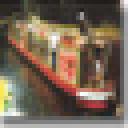
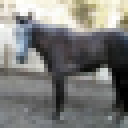
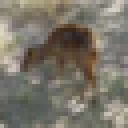
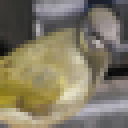
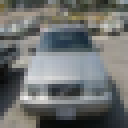
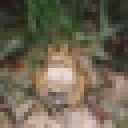
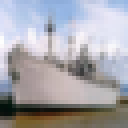
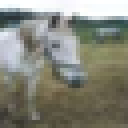
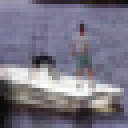
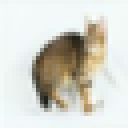

In [11]:
valset = valimgs(CIFAR10)
valimg = [getarray(valset[i].img) for i in 1:10000]
labels = onehotbatch([valset[i].ground_truth.class for i in 1:10000],1:10)
test = gpu.([(cat(valimg[i]..., dims = 4), labels[:,i]) for i in partition(1:10000, 1000)])
ids = rand(1:10000, 10)
image.(valset[ids])

In [12]:
rand_test = getarray.(image.(valset[ids]))
rand_test = cat(rand_test..., dims = 4) |> gpu
rand_truth = ground_truth.(valset[ids])
m(rand_test)


UndefVarError: UndefVarError: m not defined

In [13]:
accuracy(test[1]...)


UndefVarError: UndefVarError: m not defined

In [14]:
class_correct = zeros(10)
class_total = zeros(10)
for i in 1:10
  preds = m(test[i][1])
  lab = test[i][2]
  for j = 1:1000
    pred_class = findmax(preds[:, j])[2]
    actual_class = findmax(lab[:, j])[2]
    if pred_class == actual_class
      class_correct[pred_class] += 1
    end
    class_total[actual_class] += 1
  end
end

class_correct ./ class_total

UndefVarError: UndefVarError: m not defined